# **Model Optimization Techniques**
**Objective: Optimise CNN with tuning, compression, and deployment**

In [17]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix, classification_report

# reproducibility (best-effort)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries imported. TF version:", tf.__version__)

Libraries imported. TF version: 2.19.0


**1. LOAD & PREPROCESS DATA**

In [18]:
print("\n1) Loading and preprocessing Fashion-MNIST...")
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalise pixel values (0–255 to 0–1)
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Add channel dimension
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

# One-hot encode labels
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print(" Data loaded and preprocessed successfully!")
print(" Training set shape:", x_train.shape, y_train_cat.shape)
print(" Test set shape:", x_test.shape, y_test_cat.shape)


1) Loading and preprocessing Fashion-MNIST...
 Data loaded and preprocessed successfully!
 Training set shape: (60000, 28, 28, 1) (60000, 10)
 Test set shape: (10000, 28, 28, 1) (10000, 10)


**2. UTILS: helpers**

In [19]:
def model_size_kb(path):
    return os.path.getsize(path) / 1024

def save_model_h5(m, filename):
    # Save Keras model in single file HDF5 for easy size measurement
    m.save(filename)
    return model_size_kb(filename)

def summarize_model(m):
    params = m.count_params()
    return params

def benchmark_inference(model, X, repeats=3, n_samples=1000):
    # measure average time to predict n_samples across repeats
    n_samples = min(n_samples, X.shape[0])
    times = []
    for _ in range(repeats):
        start = time.perf_counter()
        _ = model.predict(X[:n_samples], verbose=0)
        end = time.perf_counter()
        times.append(end - start)
    avg = sum(times)/len(times)
    return avg  # seconds for n_samples

def tflite_infer_and_benchmark(tflite_path, X, n_samples=100):
    # load TFLite, run inference on n_samples and return time and one prediction
    import numpy as _np
    import tensorflow as _tf
    interpreter = _tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    # ensure dtype
    in_dtype = input_details['dtype']
    X_sub = X[:n_samples].astype(in_dtype)
    # benchmark
    start = time.perf_counter()
    for i in range(n_samples):
        interpreter.set_tensor(input_details['index'], _np.expand_dims(X_sub[i], 0))
        interpreter.invoke()
        _ = interpreter.get_tensor(output_details['index'])
    end = time.perf_counter()
    avg_time = (end - start) / n_samples
    # single prediction (first sample)
    interpreter.set_tensor(input_details['index'], _np.expand_dims(X_sub[0],0))
    interpreter.invoke()
    out = interpreter.get_tensor(output_details['index'])
    return avg_time, out

**3. BASELINE MODEL (build, train, save)**

In [20]:
print("\n2) Building baseline model...")

def build_baseline():
    model = models.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

baseline_model = build_baseline()
baseline_model.summary()

# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
ckpt_baseline = tf.keras.callbacks.ModelCheckpoint("baseline_model.h5", save_best_only=True, monitor='val_loss')

print("\nTraining baseline model (with EarlyStopping)...")
start = time.time()
history_baseline = baseline_model.fit(
    x_train, y_train_cat,
    validation_data=(x_test, y_test_cat),
    epochs=15,
    batch_size=64,
    callbacks=[es, ckpt_baseline],
    verbose=1
)
baseline_train_time = time.time() - start

# load best saved baseline weights (checkpoint ensures saved)
baseline_model = tf.keras.models.load_model("baseline_model.h5")
baseline_loss, baseline_acc = baseline_model.evaluate(x_test, y_test_cat, verbose=0)

baseline_size = model_size_kb("baseline_model.h5")
baseline_params = summarize_model(baseline_model)

print(f"\nBaseline eval -> Accuracy: {baseline_acc:.4f}, Loss: {baseline_loss:.4f}")
print(f"Baseline train time: {baseline_train_time:.2f}s, size: {baseline_size:.2f} KB, params: {baseline_params}")


2) Building baseline model...


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)


Training baseline model (with EarlyStopping)...
Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7597 - loss: 0.6767

938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.7597 - loss: 0.6765 - val_accuracy: 0.8691 - val_loss: 0.3675
Epoch 2/15
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8799 - loss: 0.3319

938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.8799 - loss: 0.3318 - val_accuracy: 0.8872 - val_loss: 0.3190
Epoch 3/15
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8957 - loss: 0.2811

938/938 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.8957 - loss: 0.2811 - val_accuracy: 0.8960 - val_loss: 0.2927
Epoch 4/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9084 - loss: 0.2471

938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9084 - loss: 0.2471 - val_accuracy: 0.9017 - val_loss: 0.2782
Epoch 5/15
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9165 - loss: 0.2211

938/938 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.9166 - loss: 0.2211 - val_accuracy: 0.9042 - val_loss: 0.2732
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.9257 - loss: 0.1974 - val_accuracy: 0.9041 - val_loss: 0.2830
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.9344 - loss: 0.1765 - val_accuracy: 0.9044 - val_loss: 0.2993
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - accuracy: 0.9426 - loss: 0.1570 - val_accuracy: 0.9063 - val_loss: 0.3035



Baseline eval -> Accuracy: 0.9042, Loss: 0.2732
Baseline train time: 312.83s, size: 2675.95 KB, params: 225034


**4. HYPERPARAMETER TUNING (multiple configs) - save best tuned model**

In [21]:
print("\n3) Hyperparameter tuning (training multiple configs)...")
param_grid = [
    {"filters": 32, "dense_units": 64,  "dropout_rate": 0.0, "lr": 0.001, "batch_size": 64},
    {"filters": 64, "dense_units": 128, "dropout_rate": 0.0, "lr": 0.001, "batch_size": 64},
    {"filters": 32, "dense_units": 128, "dropout_rate": 0.2, "lr": 0.005, "batch_size": 128},
    {"filters": 64, "dense_units": 256, "dropout_rate": 0.3, "lr": 0.005, "batch_size": 64}
]

best_tuned_metrics = None
best_tuned_path = "best_tuned_model.h5"
tuned_results = []

for i, params in enumerate(param_grid, start=1):
    print(f"\nTraining config #{i}: {params}")
    # build model according to params
    def build_tuned(filters=params["filters"], dense_units=params.get("dense_units",64), dropout_rate=params.get("dropout_rate",0.0), lr=params.get("lr",0.001)):
        model = models.Sequential([
            layers.Input(shape=(28,28,1)),
            layers.Conv2D(filters, (3,3), activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(min(filters*2, 128), (3,3), activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Flatten(),
            layers.Dense(dense_units, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(10, activation='softmax')
        ])
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    model = build_tuned()
    # callbacks with unique checkpoint name per config
    ckpt_name = f"tuned_config_{i}.h5"
    ckpt_cb = tf.keras.callbacks.ModelCheckpoint(ckpt_name, save_best_only=True, monitor='val_loss')
    es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    start = time.time()
    history = model.fit(x_train, y_train_cat,
                        validation_data=(x_test, y_test_cat),
                        epochs=15,
                        batch_size=params["batch_size"],
                        callbacks=[ckpt_cb, es_cb],
                        verbose=1)
    train_time = time.time() - start

    # load best checkpoint for evaluation
    model = tf.keras.models.load_model(ckpt_name)
    loss_val, acc_val = model.evaluate(x_test, y_test_cat, verbose=0)
    params_summary = params.copy()
    params_summary.update({"train_time_s": round(train_time,2)})
    print(f" Config {i} -> acc: {acc_val:.4f}, loss: {loss_val:.4f}, train_time: {train_time:.2f}s")
    tuned_results.append({"config": i, "params": params_summary, "acc": float(acc_val), "loss": float(loss_val), "train_time": round(train_time,2), "ckpt": ckpt_name})

    # update best
    if best_tuned_metrics is None or acc_val > best_tuned_metrics["acc"]:
        best_tuned_metrics = {"acc": float(acc_val), "loss": float(loss_val), "train_time": round(train_time,2), "path": ckpt_name, "params": params_summary}

# load best tuned model
best_tuned_model = tf.keras.models.load_model(best_tuned_metrics["path"])
best_tuned_loss, best_tuned_acc = best_tuned_model.evaluate(x_test, y_test_cat, verbose=0)
best_tuned_size = model_size_kb(best_tuned_metrics["path"])
best_tuned_params = summarize_model(best_tuned_model)

print("\nBest tuned config summary:")
print(best_tuned_metrics)
print(f"Loaded best tuned model -> acc: {best_tuned_acc:.4f}, loss: {best_tuned_loss:.4f}, size: {best_tuned_size:.2f} KB, params: {best_tuned_params}")

# Save explicitly (already saved by checkpoint but ensure filename)
best_tuned_model.save("best_tuned_model.h5")
best_tuned_size = model_size_kb("best_tuned_model.h5")


3) Hyperparameter tuning (training multiple configs)...

Training config #1: {'filters': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'lr': 0.001, 'batch_size': 64}


 Config 1 -> acc: 0.9065, loss: 0.2693, train_time: 290.19s

Training config #2: {'filters': 64, 'dense_units': 128, 'dropout_rate': 0.0, 'lr': 0.001, 'batch_size': 64}


 Config 2 -> acc: 0.9008, loss: 0.2732, train_time: 573.47s

Training config #3: {'filters': 32, 'dense_units': 128, 'dropout_rate': 0.2, 'lr': 0.005, 'batch_size': 128}


 Config 3 -> acc: 0.8939, loss: 0.2908, train_time: 264.12s

Training config #4: {'filters': 64, 'dense_units': 256, 'dropout_rate': 0.3, 'lr': 0.005, 'batch_size': 64}


 Config 4 -> acc: 0.8967, loss: 0.3172, train_time: 778.18s



Best tuned config summary:
{'acc': 0.906499981880188, 'loss': 0.2692888677120209, 'train_time': 290.19, 'path': 'tuned_config_1.h5', 'params': {'filters': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'lr': 0.001, 'batch_size': 64, 'train_time_s': 290.19}}
Loaded best tuned model -> acc: 0.9065, loss: 0.2693, size: 1468.21 KB, params: 121930


**5. MODEL COMPRESSION (Dropout model) - build & train & save**

In [22]:
print("\n4) Building and training compressed (Dropout) model...")

def build_dropout_model():
    m = models.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(32,(3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),
        layers.Conv2D(64,(3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ])
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m

dropout_model = build_dropout_model()
drop_ckpt = tf.keras.callbacks.ModelCheckpoint("dropout_model.h5", save_best_only=True, monitor='val_loss')
es_drop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start = time.time()
history_dropout = dropout_model.fit(x_train, y_train_cat,
                                    validation_data=(x_test, y_test_cat),
                                    epochs=15,
                                    batch_size=64,
                                    callbacks=[drop_ckpt, es_drop],
                                    verbose=1)
drop_train_time = time.time() - start

# load best saved dropout model
dropout_model = tf.keras.models.load_model("dropout_model.h5")
drop_loss, drop_acc = dropout_model.evaluate(x_test, y_test_cat, verbose=0)
drop_size = model_size_kb("dropout_model.h5")
drop_params = summarize_model(dropout_model)

print(f"\nDropout model -> Acc: {drop_acc:.4f}, Loss: {drop_loss:.4f}, Train time: {drop_train_time:.2f}s, Size: {drop_size:.2f} KB, Params: {drop_params}")


4) Building and training compressed (Dropout) model...
Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6974 - loss: 0.8416

938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.6975 - loss: 0.8413 - val_accuracy: 0.8590 - val_loss: 0.3873
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8489 - loss: 0.4135

938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.8489 - loss: 0.4135 - val_accuracy: 0.8774 - val_loss: 0.3318
Epoch 3/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8685 - loss: 0.3566

938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - accuracy: 0.8685 - loss: 0.3565 - val_accuracy: 0.8883 - val_loss: 0.3034
Epoch 4/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8818 - loss: 0.3238

938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.8818 - loss: 0.3238 - val_accuracy: 0.8954 - val_loss: 0.2828
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8871 - loss: 0.3047

938/938 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.8871 - loss: 0.3047 - val_accuracy: 0.8988 - val_loss: 0.2751
Epoch 6/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8944 - loss: 0.2868

938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 42ms/step - accuracy: 0.8944 - loss: 0.2868 - val_accuracy: 0.8981 - val_loss: 0.2698
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9007 - loss: 0.2684

938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.9007 - loss: 0.2684 - val_accuracy: 0.9028 - val_loss: 0.2623
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9031 - loss: 0.2626

938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.9031 - loss: 0.2626 - val_accuracy: 0.9004 - val_loss: 0.2623
Epoch 9/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9069 - loss: 0.2491

938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.9069 - loss: 0.2491 - val_accuracy: 0.9065 - val_loss: 0.2526
Epoch 10/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9111 - loss: 0.2411

938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.9111 - loss: 0.2411 - val_accuracy: 0.9074 - val_loss: 0.2488
Epoch 11/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9112 - loss: 0.2376 - val_accuracy: 0.9028 - val_loss: 0.2542
Epoch 12/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - accuracy: 0.9166 - loss: 0.2256 - val_accuracy: 0.9038 - val_loss: 0.2586
Epoch 13/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.9170 - loss: 0.2204 - val_accuracy: 0.9042 - val_loss: 0.2679



Dropout model -> Acc: 0.9074, Loss: 0.2488, Train time: 552.89s, Size: 2678.08 KB, Params: 225034


**6. DEPLOYMENT READINESS: convert dropout model to TFLite & test inference**

In [23]:
print("\n5) Converting compressed model to TFLite and testing inference...")

converter = tf.lite.TFLiteConverter.from_keras_model(dropout_model)
# Optionally enable optimizations: uncomment if you want smaller model
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_path = "dropout_model.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

tflite_size = model_size_kb(tflite_path)
print(f"TFLite model saved -> {tflite_path}, size: {tflite_size:.2f} KB")

# run tflite inference test & benchmark
tflite_avg_time_per_sample, tflite_single_out = tflite_infer_and_benchmark(tflite_path, x_test, n_samples=200)
print(f"TFLite average inference time per sample (200 samples): {tflite_avg_time_per_sample:.6f} s")
# decode single output
import numpy as _np
tflite_pred_label = _np.argmax(tflite_single_out[0])
print("TFLite single sample predicted label:", class_names[tflite_pred_label])



5) Converting compressed model to TFLite and testing inference...
Saved artifact at '/tmp/tmpuiqqfvms'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer_20')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132968065478736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132968065471632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132968065469328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132968065473552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132968065481424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132968065472208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132967897359632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132968066805648: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved -> dropout_model.tflite, size: 882.40 KB
TFLite average inference tim

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


**7. INFERENCE BENCHMARK (baseline, best tuned, dropout)**

In [24]:
print("\n6) Benchmarking inference speed for models (1000 samples)...")

n_bench = 1000 if x_test.shape[0]>=1000 else x_test.shape[0]

t_base = benchmark_inference(baseline_model, x_test, repeats=3, n_samples=n_bench)
t_tuned = benchmark_inference(best_tuned_model, x_test, repeats=3, n_samples=n_bench)
t_drop  = benchmark_inference(dropout_model, x_test, repeats=3, n_samples=n_bench)

print(f" Baseline: {t_base:.4f}s for {n_bench} samples ({t_base/n_bench:.6f}s/sample)")
print(f" Best tuned: {t_tuned:.4f}s for {n_bench} samples ({t_tuned/n_bench:.6f}s/sample)")
print(f" Dropout: {t_drop:.4f}s for {n_bench} samples ({t_drop/n_bench:.6f}s/sample)")
print(f" TFLite: {tflite_avg_time_per_sample:.6f}s/sample (measured by interpreter)")



6) Benchmarking inference speed for models (1000 samples)...
 Baseline: 0.3377s for 1000 samples (0.000338s/sample)
 Best tuned: 0.3110s for 1000 samples (0.000311s/sample)
 Dropout: 0.3441s for 1000 samples (0.000344s/sample)
 TFLite: 0.000095s/sample (measured by interpreter)


**6. EVALUATION & CONFUSION MATRIX**


7) Evaluation: confusion matrix and classification report (Dropout model)...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


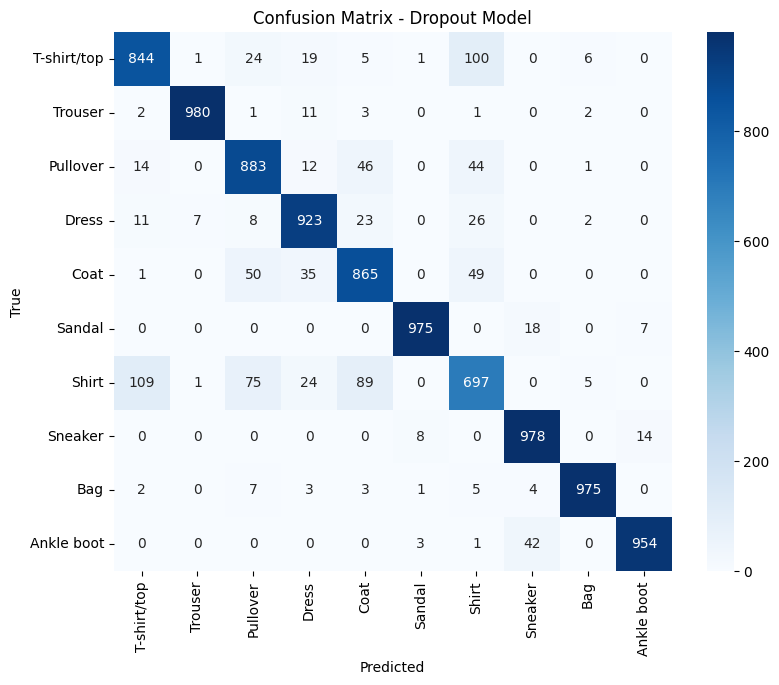


Classification Report (Dropout model):
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.84      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.84      0.88      0.86      1000
       Dress       0.90      0.92      0.91      1000
        Coat       0.84      0.86      0.85      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.76      0.70      0.72      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [25]:
print("\n7) Evaluation: confusion matrix and classification report (Dropout model)...")
y_pred_probs = dropout_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Dropout Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report (Dropout model):")
print(classification_report(y_test, y_pred, target_names=class_names))


**7. VISUALISATION COMPARISON: LOSS & ACCURACY CURVES**


8) Plotting training curves for Baseline, Best-tuned (if available) and Dropout...


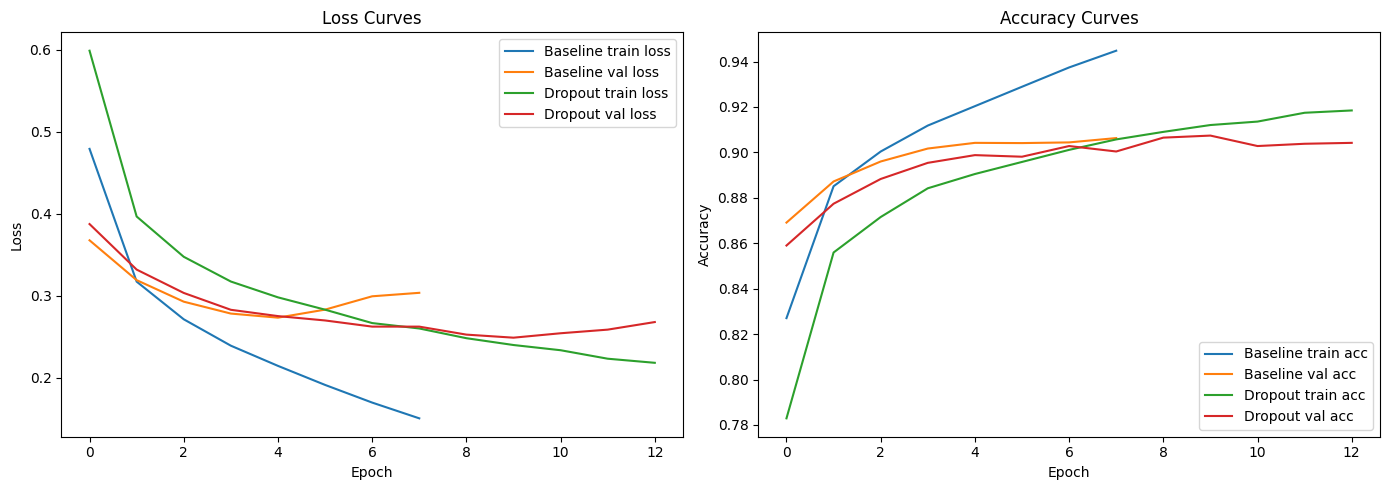

In [26]:
print("\n8) Plotting training curves for Baseline, Best-tuned (if available) and Dropout...")

plt.figure(figsize=(14,5))
# Loss
plt.subplot(1,2,1)
plt.plot(history_baseline.history['loss'], label='Baseline train loss')
plt.plot(history_baseline.history.get('val_loss', []), label='Baseline val loss')
plt.plot(history_dropout.history['loss'], label='Dropout train loss')
plt.plot(history_dropout.history.get('val_loss', []), label='Dropout val loss')
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_baseline.history['accuracy'], label='Baseline train acc')
plt.plot(history_baseline.history.get('val_accuracy', []), label='Baseline val acc')
plt.plot(history_dropout.history['accuracy'], label='Dropout train acc')
plt.plot(history_dropout.history.get('val_accuracy', []), label='Dropout val acc')
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

**10. FINAL SUMMARY TABLE**

In [27]:
print("\n9) Creating final summary table for quick comparison...")

summary = pd.DataFrame([
    {"Model": "Baseline",
     "Accuracy": round(float(baseline_acc),4),
     "Loss": round(float(baseline_loss),4),
     "Train_Time_s": round(float(baseline_train_time),2),
     "Inference_s_per_1000": round(float(t_base),3),
     "Size_KB": round(float(baseline_size),2),
     "Params": int(baseline_params)
    },
    {"Model": "Best_Tuned",
     "Accuracy": round(float(best_tuned_acc),4),
     "Loss": round(float(best_tuned_loss),4),
     "Train_Time_s": round(float(best_tuned_metrics['train_time']),2),
     "Inference_s_per_1000": round(float(t_tuned),3),
     "Size_KB": round(float(best_tuned_size),2),
     "Params": int(best_tuned_params)
    },
    {"Model": "Dropout_Compressed",
     "Accuracy": round(float(drop_acc),4),
     "Loss": round(float(drop_loss),4),
     "Train_Time_s": round(float(drop_train_time),2),
     "Inference_s_per_1000": round(float(t_drop),3),
     "Size_KB": round(float(drop_size),2),
     "Params": int(drop_params)
    },
    {"Model": "Dropout_TFLite",
     "Accuracy": round(float(drop_acc),4),     # same logical model accuracy (tflite uses same weights)
     "Loss": round(float(drop_loss),4),
     "Train_Time_s": round(float(drop_train_time),2),
     "Inference_s_per_1000": round(float(tflite_avg_time_per_sample * 1000),3),
     "Size_KB": round(float(tflite_size),2),
     "Params": int(drop_params)
    }
])

print("\n--- Final comparison table ---\n")
print(summary)

# saving summary
summary.to_csv("model_comparison_summary.csv", index=False)
print("\nSaved summary CSV: model_comparison_summary.csv")


9) Creating final summary table for quick comparison...

--- Final comparison table ---

                Model  Accuracy    Loss  Train_Time_s  Inference_s_per_1000  \
0            Baseline    0.9042  0.2732        312.83                 0.338   
1          Best_Tuned    0.9065  0.2693        290.19                 0.311   
2  Dropout_Compressed    0.9074  0.2488        552.89                 0.344   
3      Dropout_TFLite    0.9074  0.2488        552.89                 0.095   

   Size_KB  Params  
0  2675.95  225034  
1   509.11  121930  
2  2678.08  225034  
3   882.40  225034  

Saved summary CSV: model_comparison_summary.csv
